# Tutorial of mogsa using built-in data

#### Contributor: Antonio Mora, Chengshu Xie 
#### Date of first version: 2019-01-20
#### Date of last review: 2020-05-26 
#### Summary:

This is the tutorial about using how to use R package `moGSA`. We use the built-in data for this tutorial.
 . 

#### Contents:
* [1. Data Preparation](#link1)    <br>
    * [1.1 Prerequisites](#link2)     <br>
    * [1.2 Load and check data](#link3)   <br>
* [2. Method application](#link4)  <br>
* [3. Result analysis and interpretation](#link5)
    * [3.1 Example 1](#link6)
    * [3.2 Example 2](#link7)   
* [4. Plot gene sets in projected space](#link8)    
* [5. Perform MOGSA in two steps](#link9)
    
## <a id=link1>1. Data Preparation</a>

### <a id=link2>1.1 Prerequisites</a>

R package, `moGSA`, needs to be installed and loaded in the R session, this can be done easily with the following chunk of code: 

In [1]:
install.packages("BiocManager")
BiocManager::install("mogsa")
BiocManager::install("gplots")


suppressPackageStartupMessages(library(mogsa))
suppressPackageStartupMessages(library(gplots)) # used for visulizing heatmap

### <a id=link3>1.2 Load and check data</a>
`NCI60_4arrays` is a list of data.frame. The list consists of microarray data for NCI-60 cell lines from different platforms. In each of the data.frame, columns are the 60 cell lines and rows are genes. The data are from the [paper](https://www.ncbi.nlm.nih.gov/pubmed/22802077/), but only a small subset of genes were selected. Therefore, the result in this vignette is not intended for biological interpretation.<br>

`NCI60_4array_supdata` is a list of matrix, representing gene set annotation data. For each of the microarray data, there is a corresponding annotation matrix. In the annotation data, the rows are genes (in the same order as their original dataset) and columns are gene sets. An annotation matrix is a binary matrix, where 1 indicates a gene is present in a gene set and 0 otherwise. See the "Preparation of gene set data" section about how to create the gene set
annotation matrices as required by mogsa.<br>


In [2]:
# loading gene expression data and supplementary data
data(NCI60_4array_supdata)
data(NCI60_4arrays)

Check the dimension of expression data and supplymentary data, and whether they are matched in same order.

In [3]:
sapply(NCI60_4arrays, dim) # check dimensions of expression data
sapply(NCI60_4array_supdata, dim) # check dimensions of supplementary data

# check if the gene expression data and annotation data are mathced in the same order
identical(names(NCI60_4arrays), names(NCI60_4array_supdata))
head(rownames(NCI60_4arrays$agilent)) # the type of gene IDs

agilent,hgu133,hgu133p2,hgu95
300,298,268,288
60,60,60,60


agilent,hgu133,hgu133p2,hgu95
300,298,268,288
150,150,150,150


[1] TRUE

[1] "ST8SIA1" "YWHAQ"   "EPHA4"   "GTPBP5"  "PVR"     "ATP6V1H"

In [4]:
# Confirm the columns between the expression data and annotation data mapped in the same order
dataColNames = lapply(NCI60_4arrays, colnames)
supColNames = lapply(NCI60_4arrays, colnames)
identical(dataColNames, supColNames)

[1] TRUE

In [5]:
colnames(NCI60_4arrays$agilent)

[1] "BR.MCF7"        "BR.MDA_MB_231"  "BR.HS578T"      "BR.BT_549"     
 [5] "BR.T47D"        "CNS.SF_268"     "CNS.SF_295"     "CNS.SF_539"    
 [9] "CNS.SNB_19"     "CNS.SNB_75"     "CNS.U251"       "CO.COLO205"    
[13] "CO.HCC_2998"    "CO.HCT_116"     "CO.HCT_15"      "CO.HT29"       
[17] "CO.KM12"        "CO.SW_620"      "LE.CCRF_CEM"    "LE.HL_60"      
[21] "LE.K_562"       "LE.MOLT_4"      "LE.RPMI_8226"   "LE.SR"         
[25] "ME.LOXIMVI"     "ME.MALME_3M"    "ME.M14"         "ME.SK_MEL_2"   
[29] "ME.SK_MEL_28"   "ME.SK_MEL_5"    "ME.UACC_257"    "ME.UACC_62"    
[33] "ME.MDA_MB_435"  "ME.MDA_N"       "LC.A549"        "LC.EKVX"       
[37] "LC.HOP_62"      "LC.HOP_92"      "LC.NCI_H226"    "LC.NCI_H23"    
[41] "LC.NCI_H322M"   "LC.NCI_H460"    "LC.NCI_H522"    "OV.IGROV1"     
[45] "OV.OVCAR_3"     "OV.OVCAR_4"     "OV.OVCAR_5"     "OV.OVCAR_8"    
[49] "OV.SK_OV_3"     "OV.NCI_ADR_RES" "PR.PC_3"        "PR.DU_145"     
[53] "RE.786_0"       "RE.A498"        "RE.ACHN"        "RE.CAKI_1"     
[57] "RE.RXF_393"     "RE.SN12C"       "RE.TK_10"       "RE.UO_31"

In [6]:
# Before applying mogsa, we first define a factor describing the tissue of origin of cell lines 
# and color code, which will be used later.
cancerType = as.factor(substr(colnames(NCI60_4arrays$agilent), 1, 2))   # define cancer type
cancerType
colcode = cancerType # define color code to distinguish cancer types
levels(colcode) = c("black", "red", "green", "blue",
                     "cyan", "brown", "pink", "gray", "orange")
colcode = as.character(colcode)
colcode

[1] BR BR BR BR BR CN CN CN CN CN CN CO CO CO CO CO CO CO LE LE LE LE LE LE ME
[26] ME ME ME ME ME ME ME ME ME LC LC LC LC LC LC LC LC LC OV OV OV OV OV OV OV
[51] PR PR RE RE RE RE RE RE RE RE
Levels: BR CN CO LC LE ME OV PR RE

[1] "black"  "black"  "black"  "black"  "black"  "red"    "red"    "red"   
 [9] "red"    "red"    "red"    "green"  "green"  "green"  "green"  "green" 
[17] "green"  "green"  "cyan"   "cyan"   "cyan"   "cyan"   "cyan"   "cyan"  
[25] "brown"  "brown"  "brown"  "brown"  "brown"  "brown"  "brown"  "brown" 
[33] "brown"  "brown"  "blue"   "blue"   "blue"   "blue"   "blue"   "blue"  
[41] "blue"   "blue"   "blue"   "pink"   "pink"   "pink"   "pink"   "pink"  
[49] "pink"   "pink"   "gray"   "gray"   "orange" "orange" "orange" "orange"
[57] "orange" "orange" "orange" "orange"

## <a id=link4>2. Method application</a>

To run MOGSA:

In [7]:
mgsa1 = mogsa(x = NCI60_4arrays, sup=NCI60_4array_supdata, nf=3,
               proc.row = "center_ssq1", w.data = "inertia", statis = TRUE)

In [8]:
mgsa1

$`@call`
mogsa(x = NCI60_4arrays, sup = NCI60_4array_supdata, nf = 3, 
    proc.row = "center_ssq1", w.data = "inertia", statis = TRUE)

$`@moa`
$`@moa`$`@call`
moa(data = data, proc.row = proc.row, w.data = w.data, w.row = w.row, 
    statis = statis)

$`@moa`$`@tab.dim`
    agilent hgu133 hgu133p2 hgu95
row     300    298      268   288
col      60     60       60    60

$`@moa`$`@ids`
$`@moa`$`@ids`$agilent
[1] "ST8SIA1" "YWHAQ"   "EPHA4"   "GTPBP5"  "PVR"     "ATP6V1H"

$`@moa`$`@ids`$hgu133
[1] "SDC1"    "CD3D"    "GPR137B" "GSDMB"   "ANO9"    "AREG"   

$`@moa`$`@ids`$hgu133p2
[1] "RAB1A"     "LOC441108" "HSPA2"     "SNCA"      "CSNK2A2"   "MXD4"     

$`@moa`$`@ids`$hgu95
[1] "USE1"    "ARHGAP8" "ASS1"    "TSPAN4"  "ITSN1"   "CITED1" 


$`@moa`$`@RV`
           agilent    hgu133  hgu133p2     hgu95
agilent  1.0000000 0.8140001 0.8120062 0.8323821
hgu133   0.8140001 1.0000000 0.9235320 0.9437341
hgu133p2 0.8120062 0.9235320 1.0000000 0.9273373
hgu95    0.8323821 0.9437341 0.92733

## <a id=link5>3. Result analysis and interpretation</a> 
The `mogsa` function returns an object of class `mgsa`. This information could be extracted with function `getmgsa`. First, we want to know the variance explained by each PC on different datasets.

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agilent,0.0005406833,0.0004119778,0.0002410063,0.0004038087,0.0001317894,0.0001783712,0.0001102046,7.647035e-05,9.255591e-05,7.623495e-05,...,1.766688e-05,1.573844e-05,1.789202e-05,1.588216e-05,1.371554e-05,1.489570e-05,1.278135e-05,7.710620e-06,8.292575e-06,4.905560e-34
hgu133,0.0007410830,0.0005850680,0.0003507538,0.0001448788,0.0001685482,0.0001042850,0.0001141451,9.152286e-05,9.233171e-05,8.127548e-05,...,1.927263e-05,2.064648e-05,1.792612e-05,1.790954e-05,2.044984e-05,1.566760e-05,1.370311e-05,1.091389e-05,1.483197e-05,6.034980e-34
hgu133p2,0.0007716595,0.0005146566,0.0003742008,0.0001281515,0.0001487516,0.0001203610,0.0001037556,1.040017e-04,8.616141e-05,7.889696e-05,...,2.031250e-05,1.823293e-05,1.816761e-05,1.960108e-05,1.496160e-05,1.722105e-05,1.638918e-05,2.228523e-05,9.725357e-06,6.495037e-34
hgu95,0.0008042677,0.0006210049,0.0003942394,0.0001506287,0.0001752495,0.0001102364,0.0001208737,1.189579e-04,7.304858e-05,9.072314e-05,...,1.909173e-05,1.862061e-05,1.791124e-05,1.626488e-05,1.875370e-05,1.442530e-05,1.471469e-05,1.052441e-05,8.879026e-06,6.808613e-34


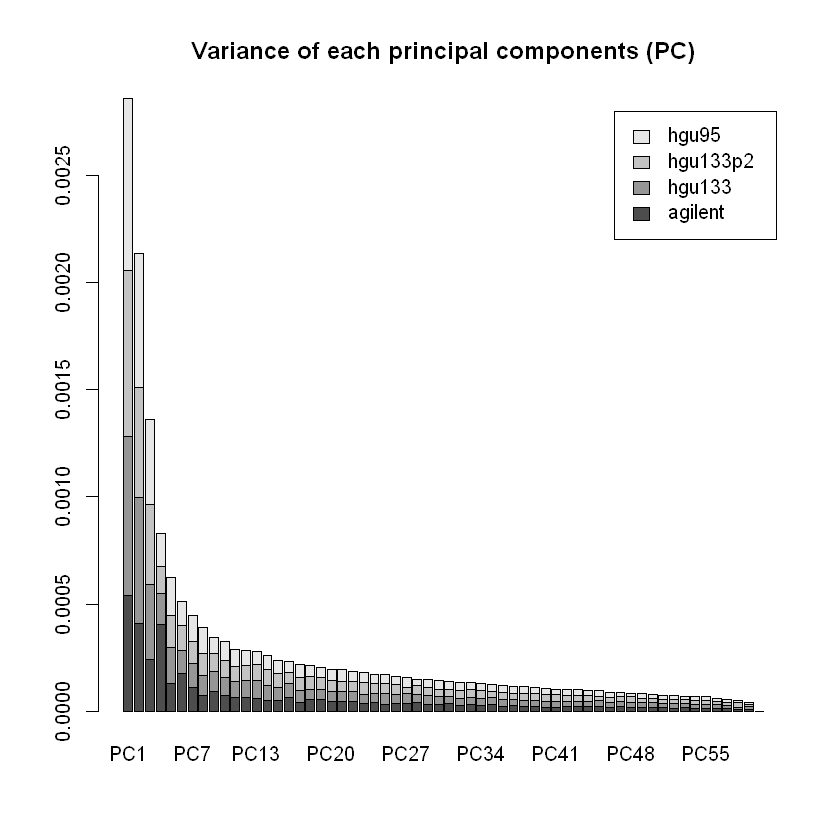

In [9]:
eigs = getmgsa(mgsa1, "partial.eig") # get partial "eigenvalue" for separate data
eigs
barplot(as.matrix(eigs), legend.text = rownames(eigs), 
        main = "Variance of each principal components (PC)")
# the contributions of different data are distinguished by different colors

,BR.MCF7,BR.MDA_MB_231,BR.HS578T,BR.BT_549,BR.T47D,CNS.SF_268,CNS.SF_295,CNS.SF_539,CNS.SNB_19,CNS.SNB_75,...,PR.PC_3,PR.DU_145,RE.786_0,RE.A498,RE.ACHN,RE.CAKI_1,RE.RXF_393,RE.SN12C,RE.TK_10,RE.UO_31
ORGANELLE_PART,0.0008387807,-3.229068e-04,-9.590523e-04,-0.0004725457,1.820676e-04,-0.0007320322,-7.627032e-04,-1.050955e-03,-0.0005156010,-0.0012114695,...,-5.418904e-05,-7.800383e-05,-3.916225e-04,-0.0010197994,-6.114488e-04,-5.037607e-04,-0.0008599458,-3.332888e-04,-0.0002304620,-0.0007580615
INTRINSIC_TO_PLASMA_MEMBRANE,-0.0010653632,8.815431e-04,1.745199e-03,0.0012010273,-1.205989e-04,0.0014703266,1.334184e-03,1.837182e-03,0.0009680169,0.0019534267,...,2.613985e-04,4.896836e-04,1.145418e-03,0.0019890069,1.455491e-03,1.245439e-03,0.0018334082,9.558258e-04,0.0008956653,0.0016253084
CYTOPLASMIC_PART,-0.0004609780,-2.903411e-04,-6.043233e-05,-0.0004874490,1.886775e-04,-0.0003768300,-7.114874e-06,-2.115503e-05,-0.0002862945,0.0001539046,...,1.123678e-04,-3.890340e-06,-3.321441e-04,0.0003636761,1.147635e-04,1.899145e-05,-0.0001352645,-3.291699e-04,-0.0001543579,0.0001492384
NON_MEMBRANE_BOUND_ORGANELLE,0.0004135920,-5.128751e-05,-3.721301e-04,-0.0001420564,2.382183e-04,-0.0003121686,-3.120595e-04,-4.341660e-04,-0.0002625194,-0.0005334135,...,1.019114e-04,1.562619e-04,-1.518226e-05,-0.0001921503,-6.318203e-06,-3.758710e-06,-0.0002149098,-3.744667e-05,0.0001224327,-0.0001016338
INTEGRAL_TO_MEMBRANE,-0.0012860465,1.136110e-03,2.169784e-03,0.0015008420,-2.123663e-05,0.0017919690,1.649184e-03,2.267395e-03,0.0011465283,0.0023943109,...,4.187309e-04,7.426462e-04,1.507399e-03,0.0026394667,1.982591e-03,1.688373e-03,0.0023607352,1.239446e-03,0.0012587919,0.0021682639
INTEGRAL_TO_PLASMA_MEMBRANE,-0.0010408568,8.661045e-04,1.712625e-03,0.0011846249,-1.300428e-04,0.0014501870,1.309378e-03,1.803438e-03,0.0009576398,0.0019161125,...,2.481922e-04,4.710082e-04,1.122516e-03,0.0019339026,1.413822e-03,1.211511e-03,0.0017945670,9.387664e-04,0.0008706198,0.0015816539


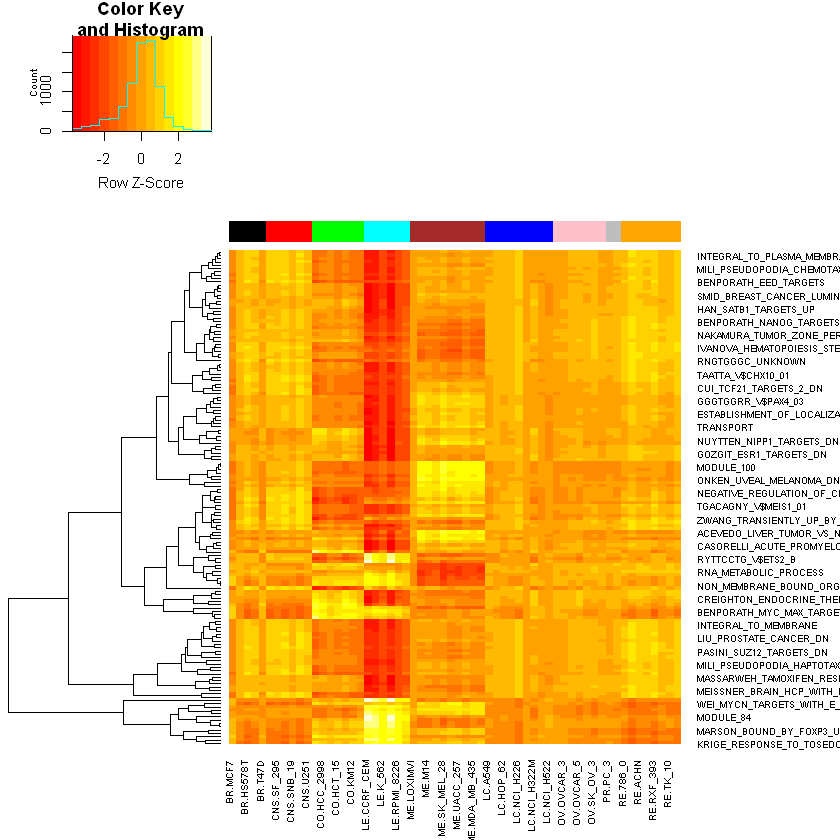

In [10]:
# The main result returned by `mogsa` is the gene set score (GSS) matrix. The value in the
# matrix indicates the overall active level of a gene set in a sample. 
# get the score matrix
scores = getmgsa(mgsa1, "score")
head(scores)
heatmap.2(scores, trace = "n", scale = "r", Colv = NULL, dendrogram = "row", 
          margins = c(6, 10), ColSideColors=colcode)
# heatmap showing the gene set score (GSS) matrix

The heatmap shows the gene set score matrix returned by `mogsa`. The rows of the matrix are all the gene sets used to annotate the data. But we are mostly interested in the gene sets with large number of significant gene sets, because these gene sets describe the difference across cell lines. The corresponding p-value for each gene set score could be extracted by `getmgsa`. Then, the most significant gene sets could be defined as gene sets that contain highest number of significantly p-values.

,BR.MCF7,BR.MDA_MB_231,BR.HS578T,BR.BT_549,BR.T47D,CNS.SF_268,CNS.SF_295,CNS.SF_539,CNS.SNB_19,CNS.SNB_75,...,PR.PC_3,PR.DU_145,RE.786_0,RE.A498,RE.ACHN,RE.CAKI_1,RE.RXF_393,RE.SN12C,RE.TK_10,RE.UO_31
ORGANELLE_PART,0.010838064,0.260028103,0.0579354203,0.295235665,0.8353120,0.169677506,0.0511843236,0.053471684,0.209657498,0.0359038523,...,0.3875927,0.48319866,0.263403241,0.0205596709,0.079771368,0.101455365,0.0774197470,0.285498217,0.351285020,0.0453042253
INTRINSIC_TO_PLASMA_MEMBRANE,0.004402244,0.002946150,0.0009834800,0.002793480,0.3758081,0.002180097,0.0010664931,0.001115843,0.004104555,0.0012967586,...,0.3223773,0.16530786,0.004292608,0.0009832709,0.004740550,0.004554495,0.0010267330,0.003571865,0.030541811,0.0016632384
CYTOPLASMIC_PART,0.357206926,0.344739257,0.8291806974,0.327260180,0.8992935,0.544320870,0.9016393178,0.894747676,0.581395304,0.9151902838,...,0.9675536,0.62833887,0.360593081,0.9313594844,0.794363540,0.699082690,0.6563726005,0.326717881,0.465227549,0.8653488335
NON_MEMBRANE_BOUND_ORGANELLE,0.137654244,0.809146193,0.3834832277,0.749153363,0.5658399,0.527284907,0.3486428906,0.350703304,0.500521748,0.2795958838,...,0.8779173,0.80484848,0.871716146,0.4230207400,0.689097526,0.726024448,0.5394877191,0.852614897,0.932323607,0.5481024061
INTEGRAL_TO_MEMBRANE,0.003741840,0.001085903,0.0004910321,0.001378463,0.5564561,0.001372849,0.0005791171,0.000618479,0.003388107,0.0008059845,...,0.1491652,0.06652218,0.001374969,0.0002123348,0.001078849,0.001082565,0.0003291563,0.001277826,0.009439984,0.0003736212
INTEGRAL_TO_PLASMA_MEMBRANE,0.005128230,0.003277122,0.0011348312,0.002993959,0.3569682,0.002345113,0.0012272444,0.001279169,0.004267741,0.0014947659,...,0.3543484,0.18235758,0.004853992,0.0012857146,0.005862200,0.005552231,0.0012225304,0.003970734,0.034668291,0.0021021761


[1] "PASINI_SUZ12_TARGETS_DN"                        
 [2] "CHARAFE_BREAST_CANCER_LUMINAL_VS_BASAL_DN"      
 [3] "CHARAFE_BREAST_CANCER_LUMINAL_VS_MESENCHYMAL_DN"
 [4] "KOINUMA_TARGETS_OF_SMAD2_OR_SMAD3"              
 [5] "DUTERTRE_ESTRADIOL_RESPONSE_24HR_DN"            
 [6] "REN_ALVEOLAR_RHABDOMYOSARCOMA_DN"               
 [7] "LIM_MAMMARY_STEM_CELL_UP"                       
 [8] "LIU_PROSTATE_CANCER_DN"                         
 [9] "CHICAS_RB1_TARGETS_CONFLUENT"                   
[10] "NUYTTEN_EZH2_TARGETS_UP"                        
[11] "DACOSTA_UV_RESPONSE_VIA_ERCC3_DN"               
[12] "PUJANA_ATM_PCC_NETWORK"                         
[13] "KRIGE_RESPONSE_TO_TOSEDOSTAT_24HR_DN"           
[14] "WONG_ADULT_TISSUE_STEM_MODULE"                  
[15] "KRIEG_HYPOXIA_NOT_VIA_KDM3A"                    
[16] "MULTICELLULAR_ORGANISMAL_DEVELOPMENT"           
[17] "ANATOMICAL_STRUCTURE_DEVELOPMENT"               
[18] "FORTSCHEGGER_PHF8_TARGETS_DN"                   
[19] "ZWANG_CLASS_1_TRANSIENTLY_INDUCED_BY_EGF"       
[20] "PLASMA_MEMBRANE_PART"

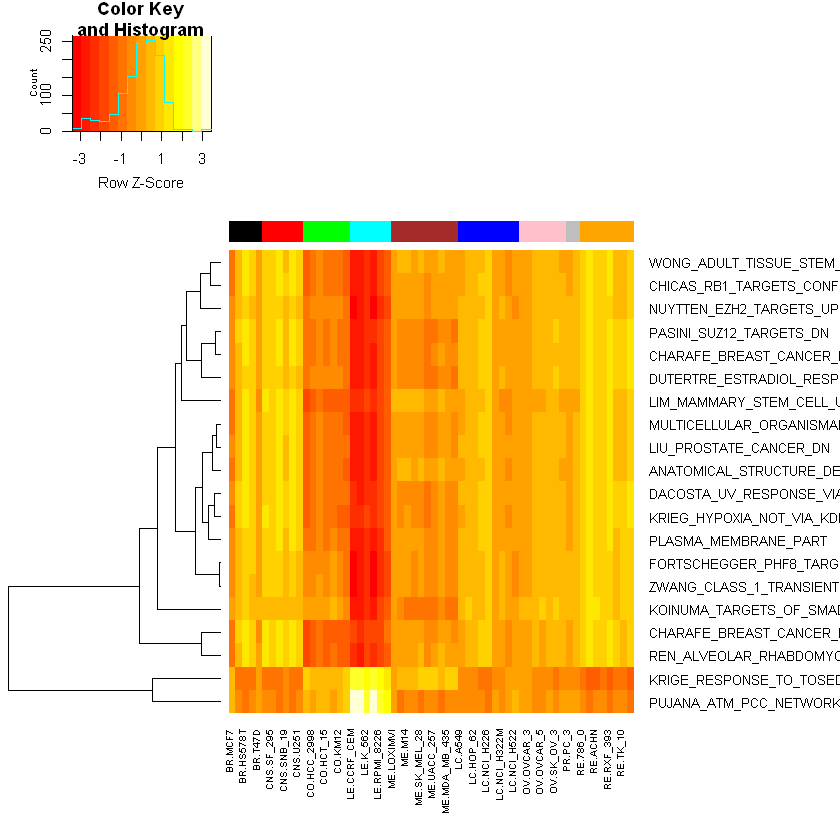

In [11]:
# to select the top 20 most significant gene sets and plot them in heatmap
p.mat = getmgsa(mgsa1, "p.val") # get p value matrix
head(p.mat)
top.gs = sort(rowSums(p.mat < 0.01), decreasing = TRUE)[1:20]  # select gene sets with most signficant GSS scores.
top.gs.name = names(top.gs)
top.gs.name
heatmap.2(scores[top.gs.name, ], trace = "n", scale = "r", Colv = NULL, dendrogram = "row",
          margins = c(8, 13), ColSideColors=colcode)

# heatmap showing the gene set score (GSS) matrix for top 20 significant gene sets

### <a id=link6>3.1 Example 1</a>
In the first example, we explore the gene set that have most significant gene set scores.

[1] "PASINI_SUZ12_TARGETS_DN"

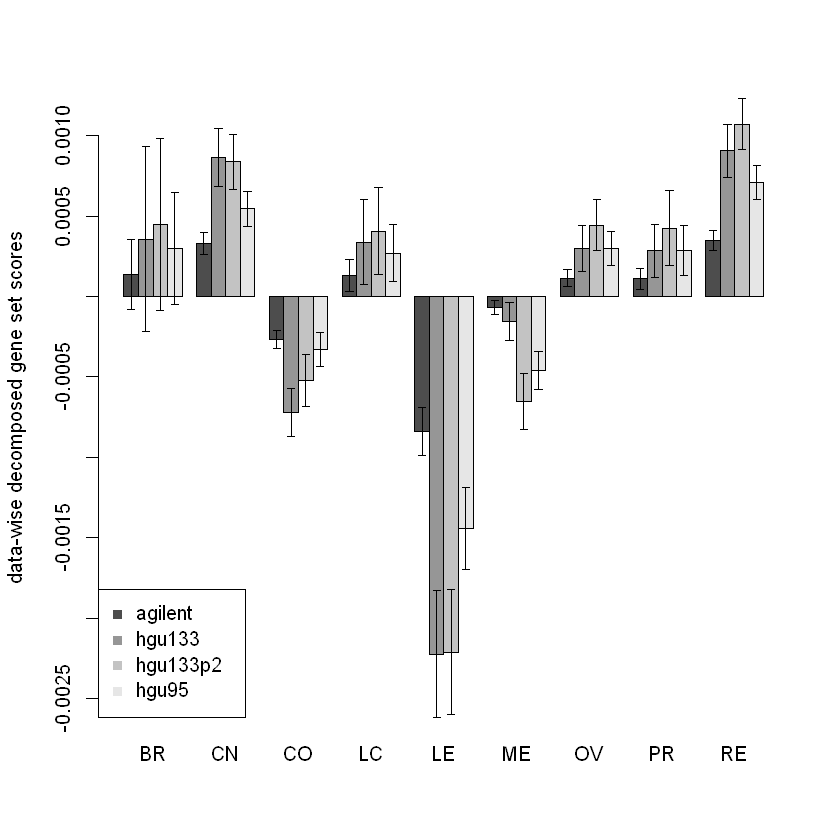

In [12]:
# gene set score decomposition
# we explore two gene sets, the first one
gs1 = top.gs.name[1] # select the most significant gene set
gs1

# decompose the gene set score over datasets
decompose.gs.group(mgsa1, gs1, group = cancerType)
 
# The GSS decomposition are grouped according to the tissue of origin of cell lines. 
# The vertical bar showing the 95% of confidence interval of the means.
# the plot shows leukemia cell lines have lowest GSS on this gene set. The contribution to 
# the overall gene set score by each dataset are separated in this plot. In general, there is a
# good concordance between different datasets. But HGU133 platform contribute most and
# Agilent platform contributed least comparing with other datasets, represented as the longest or shortest bars

,feature,GIS,data
,<chr>,<dbl>,<fct>
1,LIMD2,1.007091,hgu133
2,ZNF266,1.006706,hgu133
3,LIMD2,1.006476,hgu95
4,GNG2,1.006327,agilent
5,SP5,1.006035,hgu95
6,SP5,1.005954,hgu133


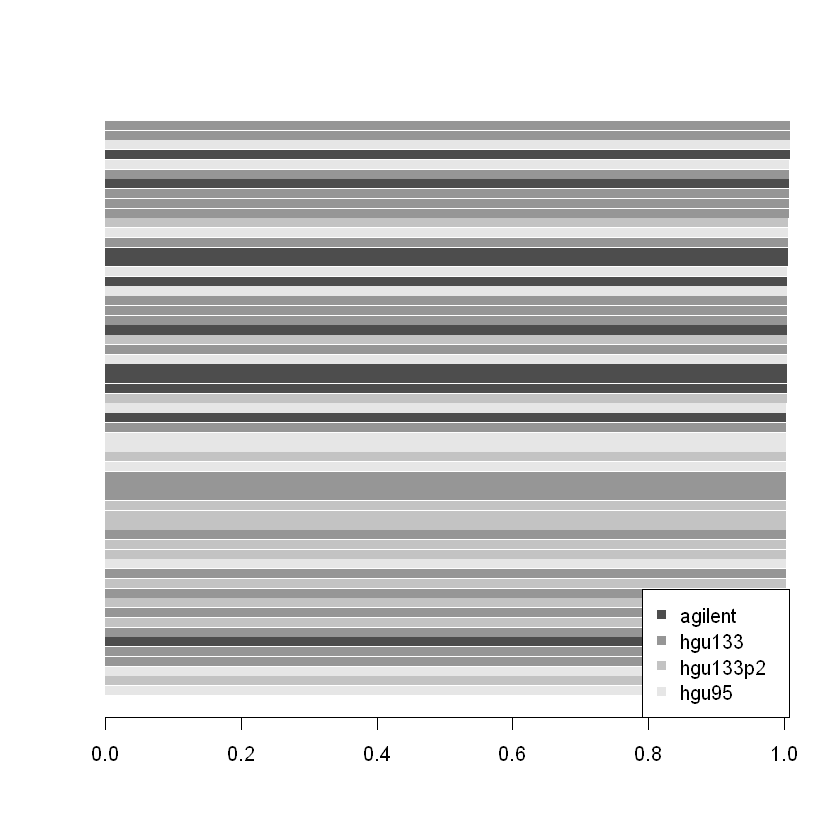

In [13]:
# to know the most influential genes in this gene set
gis1 = GIS(mgsa1, gs1, barcol = gray.colors(4)) # gene influential score
head(gis1) # print top 6 influencers

# the GIS are represented as bars and the original data where the gene is from is distingished by different colors.

The bars represent the gene influential scores for genes. Genes from different platforms are shown in different colors. The expression of genes with high positive GIS more likely to have a good positive correlation with the gene set score. In this example, the most important genes in the gene set "PASIN SUZ12 TARGETS DN" are TNFRSF12A (identified in two different platforms), CD151, ITGB1, etc.<br>
条形代表基因的基因影响因子。来自不同平台的基因以不同颜色显示。具有高阳性GIS的基因的表达更可能与基因组得分具有良好的正相关性。|在该实施例中，基因组“PASIN SUZ12 TARGETS DN”中最重要的基因是TNFRSF12A（在两个不同平台中鉴定），CD151，ITGB1等。

### <a id=link7>3.2 Example 2</a>

In this example, we use the same methods to explore the "PUJANA ATM PCC NETWORK" gene set.<br>

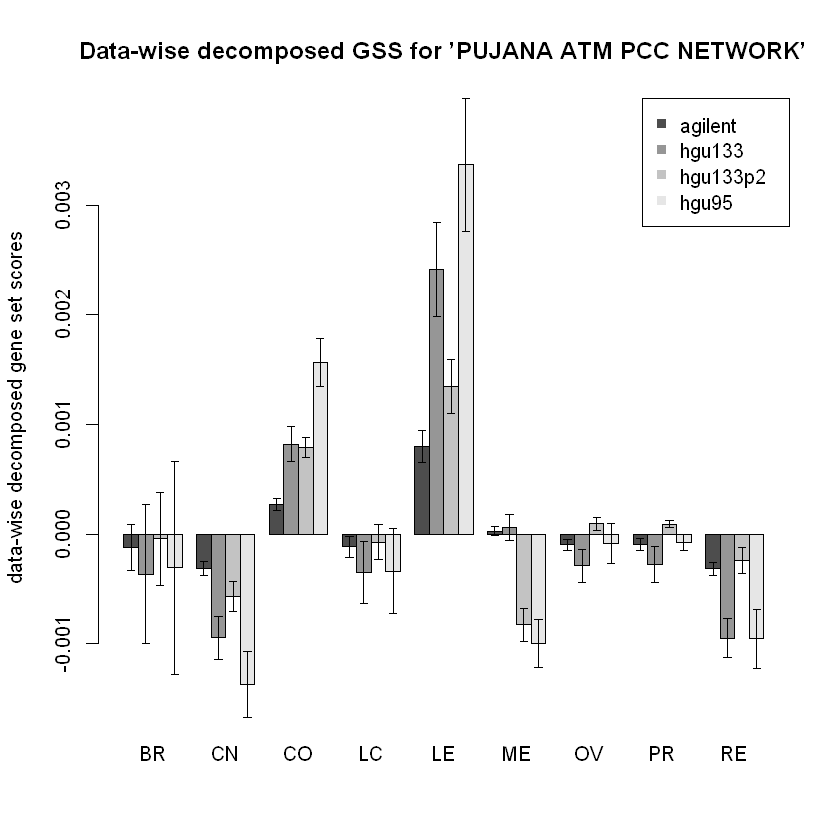

In [14]:
# the section gene set
gs2 = "PUJANA_ATM_PCC_NETWORK"
decompose.gs.group(mgsa1, gs2, group = cancerType, x.legend = "topright", 
                   main = "Data-wise decomposed GSS for ’PUJANA ATM PCC NETWORK’")

This bar shows that the the leukemia cell lines have highest GSSs for this gene set. And the HGU133 and HGU95 platform have relative high contribution to the overall gene set score.<br>

该条显示白血病细胞系具有该基因组的最高GSS。 HGU133和HGU95平台对整体基因组评分的贡献相对较高。

,feature,GIS,data
,<chr>,<dbl>,<fct>
1,PCBP4,1.007281,agilent
2,LIF,1.006737,hgu133
3,DKK3,1.006393,hgu133p2
4,ROBO1,1.006231,hgu95
5,GPD2,1.006213,hgu133
6,KCNMA1,1.006116,hgu133p2


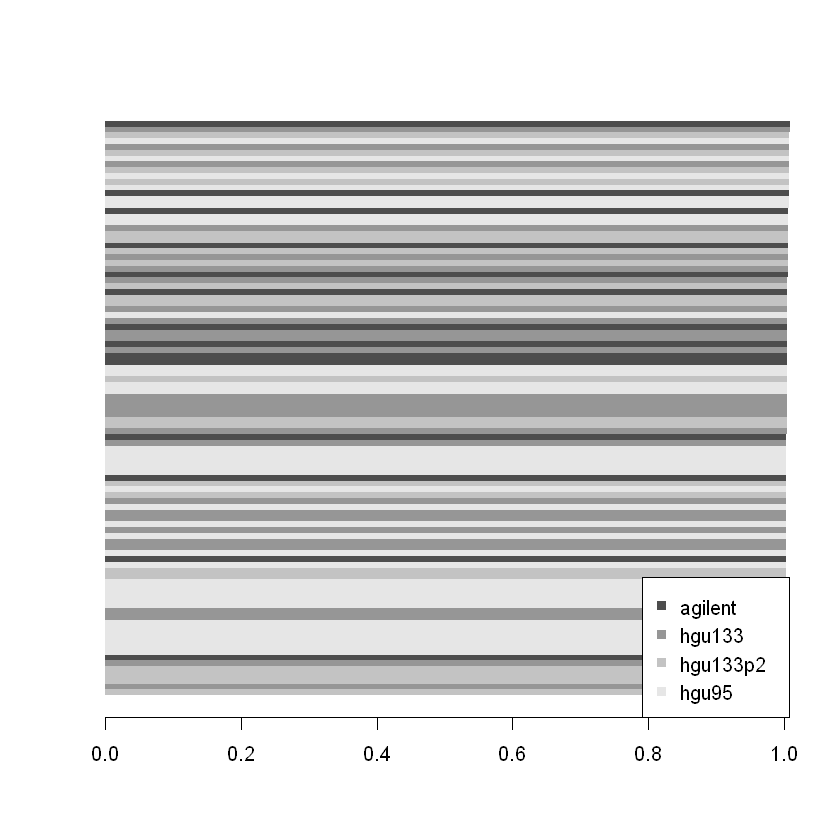

In [15]:
gis2 = GIS(mgsa1, "PUJANA_ATM_PCC_NETWORK", topN = 6, barcol = gray.colors(4))
gis2 # GIS plot for gene set ’PUJANA ATM PCC NETWORK'

The GIS analysis indicates the PIK4CG and GMFG are the most important genes in this gene set.<br>

## <a id=link8>4. Plot gene sets in projected space</a>

We can also see how the gene set are presented in the lower dimension space. Here we show the projection of gene set annotations on first two dimensions. 

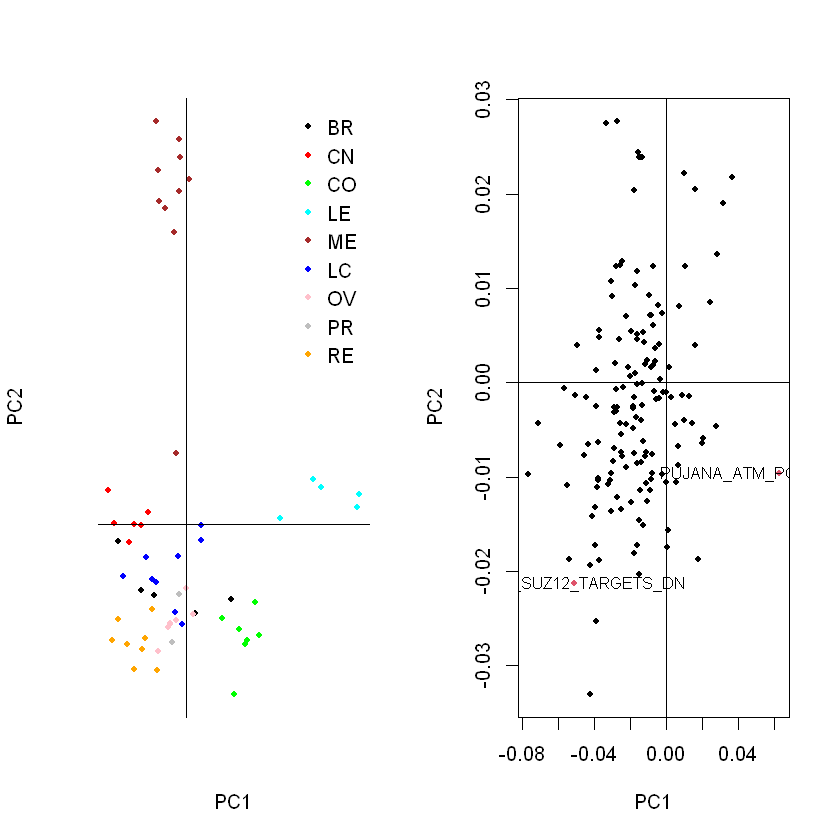

In [16]:
fs = getmgsa(mgsa1, "fac.scr") # extract the factor scores for cell lines (cell line space)
layout(matrix(1:2, 1, 2))
plot(fs[, 1:2], pch=20, col=colcode, axes = FALSE)
abline(v=0, h=0)
legend("topright", col=unique(colcode), pch=20, legend=unique(cancerType), bty = "n")

# cell line and gene sets projected on the PC1 and PC2
plotGS(mgsa1, label.cex = 0.8, center.only = TRUE, topN = 0, label = c(gs1, gs2))

## <a id=link9>5. Perform MOGSA in two steps</a>

`mogsa` perform MOGSA in one step. But in practice, one need to determine how many PCs should be retained in the step of reconstructing gene set score matrix. 

,PC1,PC2,PC3,PC4,PC5,PC6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agilent,0.0005406833,0.0004119778,0.0002410063,0.0004038087,0.0001317894,0.0001783712
hgu133,0.0007410830,0.0005850680,0.0003507538,0.0001448788,0.0001685482,0.0001042850
hgu133p2,0.0007716595,0.0005146566,0.0003742008,0.0001281515,0.0001487516,0.0001203610
hgu95,0.0008042677,0.0006210049,0.0003942394,0.0001506287,0.0001752495,0.0001102364


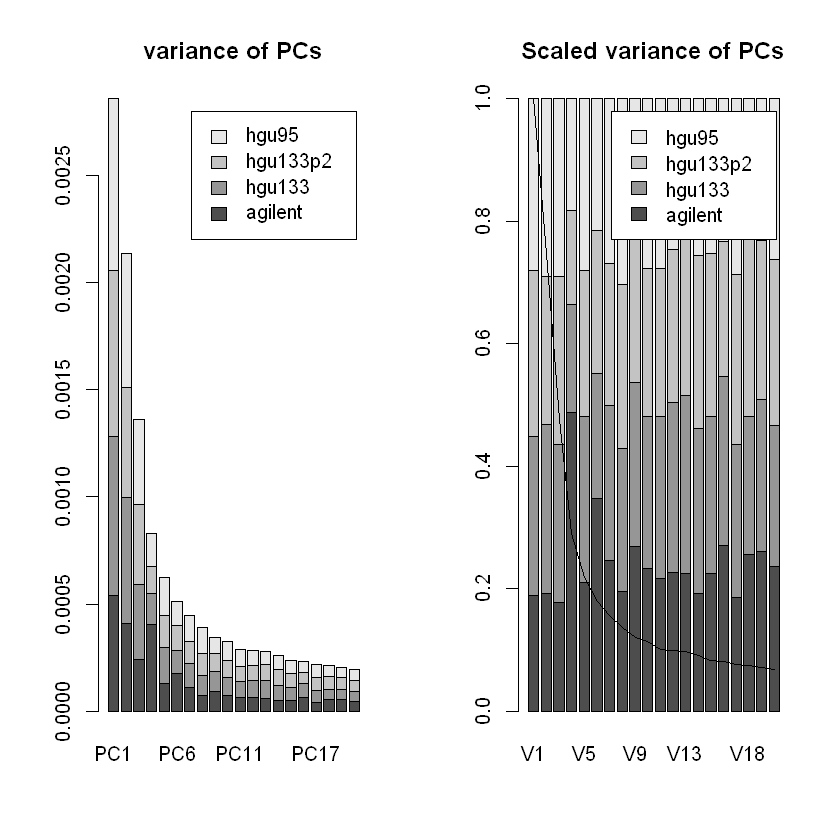

In [17]:
# perform multivariate analysis
ana = moa(NCI60_4arrays, proc.row = "center_ssq1", w.data = "inertia", statis = TRUE)
slot(ana, "partial.eig")[, 1:6] # extract the eigenvalue

# show the eigenvalues in scree plot:
layout(matrix(1:2, 1, 2))
# cell line and gene sets projected on the PC1 and PC2
plot(ana, value="eig", type = 2, n=20, main="variance of PCs") 
plot(ana, value="tau", type = 2, n=20, main="Scaled variance of PCs")

The multivariate analysis (moa) returns an object of class `moa-class`. The scree plot shows the top 3 PC is the most significant since they explain much more variance than others. Several other methods, such as the informal "elbow test" or more formal test could be used to determine the number of retained PCs. In order to be consistent with previous example, we use top 3 PCs in the analysis.

In [18]:
mgsa2 = mogsa(x = ana, sup=NCI60_4array_supdata, nf=3)

x is an object of "moa", statis is not used

In [19]:
identical(mgsa1, mgsa2) # check if the two methods give the same results

[1] FALSE

In [20]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18363)

Matrix products: default

locale:
[1] LC_COLLATE=Chinese (Simplified)_China.936 
[2] LC_CTYPE=Chinese (Simplified)_China.936   
[3] LC_MONETARY=Chinese (Simplified)_China.936
[4] LC_NUMERIC=C                              
[5] LC_TIME=Chinese (Simplified)_China.936    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] gplots_3.0.3 mogsa_1.21.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6         pillar_1.4.4         compiler_4.0.0      
 [4] bitops_1.0-6         base64enc_0.1-3      tools_4.0.0         
 [7] digest_0.6.25        uuid_0.1-4           bit_1.1-15.2        
[10] checkmate_2.0.0      lattice_0.20-41      jsonlite_1.6.1      
[13] annotate_1.66.0      evaluate_0.14        RSQLite_2.2.0       
[16] memoise_1.1.0        rlang_0.4.6          graph_1.66.0        
[19] Mat